In [11]:
import pandas as pd
import numpy as np
import pickle

In [2]:
#Uncomment the line below to install stanza
#!pip install stanza

In [9]:
from util import spacy_get_sents, stanza_get_sents, spacy_tokenize_text, stanza_tokenize_text, get_texts

In [10]:
from util import get_tokens_dict, common_tokens

# Data collection

For our further inverstigations we will choose 100 texts from "Writers" category that we previously stored:

In [12]:
texts = get_texts(source_type='folder', path='Writers', token_type='file', n=100)

Below we can see the sample of 5 files from the dataset:

In [13]:
texts[:5]

['Anne Von Bertouch, (29 June 1915 – 31 March 2003) was an Australian art dealer, author, environmentalist and director of the Von Bertouch Galleries in Newcastle, New South Wales, believed to be the first commercial gallery outside a capital city in Australia. Biography Born Anne Catherine, to parents Jean (née Duff) and George Whittle on 29 June 1915 in Eastwood, New South Wales, she was educated at Sydney Girls High School and Armidale Teachers College. After teacher training her first posting was at Adamstown Infants School in the 1930s. She married Roger Von Bertouch in 1939. In 1941 she was the organiser of a National Fitness Camp for girls at Broken Bay, New South Wales.She and Roger moved to Tasmania, where they taught and she studied at Hobart Technical College. In 1942 she performed modern interpretive dance at a Town Hall concert in Hobart organised by the Australian Broadcasting Commission Patriotic Committee as a fundraiser on Allies\' Appeal Day. She danced also in Hobart

# Sentence segmentation

For our selected 100 articles we will perform sentence tokenization using Spacy and Stanza.
Each file will be separated into sentences separately.

In [14]:
spacy_sents = [spacy_get_sents(x) for x in texts]

In [15]:
# To run for the first time Stanza tokenization:
""" 
stanza_sents = [stanza_get_sents(x) for x in texts]
with open('SpacyStanza/stanza_sents.pickle', 'wb') as f:
    pickle.dump(stanza_sents, f))

"""

# To load Stanza tokens from a pickle file

with open('SpacyStanza/stanza_sents.pickle', 'rb') as f:
    stanza_sents = pickle.load(f)

We can now show the number of sentences calculated by each library for our articles:

In [16]:
sents_df = pd.DataFrame(columns=['Spacy', 'Stanza'])

sents_df.Spacy = list(map(lambda x: len(x), spacy_sents))
sents_df.Stanza = list(map(lambda x: len(x), stanza_sents))

sents_df

,Spacy,Stanza
0,107,95
1,37,33
2,8,9
3,35,27
4,28,29
...,...,...
95,32,30
96,21,11
97,18,17
98,7,7


We can look at the stats for all articles, it appears that Spacy on average finds more sentences:

In [17]:
sents_df.describe()

,Spacy,Stanza
count,100.000000,100.000000
mean,30.770000,28.230000
std,26.211978,24.465129
min,3.000000,3.000000
25%,13.000000,11.000000
50%,25.000000,21.500000
75%,37.000000,33.250000
max,155.000000,143.000000


Below we can see the total number of sentences recognized by the both libraries:

In [18]:
sents_df.sum()

Spacy     3077
Stanza    2823
dtype: int64

We can notice that overall Stanza splits into sentences less frequently than Spacy does.

_____________

Now we can find all unique sentences that both recognize.
First we can look at the number shared sentences per article:

In [19]:
# Make a set of unique sentences for each article for both Spacy and Stanza.
# Find the intersection = these are sentences recognized by both libraries.

shared_sents_per_article = list(map(lambda x,y: set(x).intersection(set(y)), spacy_sents, stanza_sents))

shared_sents_per_article_df = pd.DataFrame(columns=['shared_sents', 'count'])
shared_sents_per_article_df['shared_sents'] = shared_sents_per_article
shared_sents_per_article_df['count'] = [len(x) for x in shared_sents_per_article]
shared_sents_per_article_df

,shared_sents,count
0,"{They mustn't attempt to please., In 1941 she ...",68
1,{He has been an invitee to numerous events on ...,24
2,{John Peck is an American Marine sergeant who ...,7
3,"{A statue of him, unveiled in 1950, stands at ...",12
4,{Northcroft graduated with an MA in English li...,27
...,...,...
95,"{According to Yehuda Marton, an Israeli-Hungar...",26
96,"{In Aghmat, in the year 1190, he wrote a Talmu...",10
97,"{Sir John Jervis White Jervis, 1st Baronet (17...",12
98,"{Notes, From 1968 to 1987, he was rector of Ch...",7


Below is the overall count of shared sentences:

In [20]:
total_sp_sent = sents_df.sum()['Spacy']
total_st_sent = sents_df.sum()['Stanza']
total_shared = shared_sents_per_article_df['count'].sum()

print(f"""
    Total Spacy sentences: {total_sp_sent}
    Total Stanza sentences: {total_st_sent}
    Shared sentences: {total_shared}
    Percentage of shared sentences for Spacy: {100*total_shared/total_sp_sent:.2f}%
    Percentage of shared sentences for Stanza: {100*total_shared/total_st_sent:.2f}%""")


    Total Spacy sentences: 3077
    Total Stanza sentences: 2823
    Shared sentences: 2263
    Percentage of shared sentences for Spacy: 73.55%
    Percentage of shared sentences for Stanza: 80.16%


We can also have a look at what different articles both libraries found looking at the first mismatched sentence pair 
for each article:

In [21]:
def get_first_mismatched_sent_pair(sp_sents, st_sents):
    n = len(sp_sents)
    m = len(st_sents)
    
    # Go through the array of sentences for both Spacy and Stanza till the end of smallest of them.
    for i in range(min(n, m)):
        # When we reach the first mismatch, print the sentences.
        if sp_sents[i] != st_sents[i]:
            print(f'Spacy sentence: {sp_sents[i]} \n\n'
            f'Stanza sentence: {st_sents[i]}\n'
            '_______________')
            return sp_sents[i], st_sents[i]
    
    # If there was no mismatch during the array traversal, then all the sentences were tokenized together.
    print('Text segmentized into sentences in the same way.\n_______________')
    return None

for i, pair in list(enumerate(zip(spacy_sents, stanza_sents)))[:20]:
    print(f'Article: {i}\n\n')
    get_first_mismatched_sent_pair(pair[0], pair[1])

Article: 0


Spacy sentence: She danced also in Hobart's Opera And Ballet Festival for International Week in 1945.Intending to develop land and to pursue their artistic interests, they moved to Mungo Brush in the Myall Lakes, New South Wales, in 1951 or 1954, living a subsistence existence from prawn fishing and trading their home-grown produce, and were appointed Honorary Rangers there in 1955 under the Wild Flowers and Native Plants Protection Act. 

Stanza sentence: She danced also in Hobart's Opera And Ballet Festival for International Week in 1945.
_______________
Article: 1


Spacy sentence: ISBN 9782844096265, 

Stanza sentence: ISBN 9782844096265, ASIN B07TTX6ZHQ
_______________
Article: 2


Spacy sentence: He successfully underwent a ground-breaking bilateral arm transplant in August 2016.Peck wrote a book, Rebuilding Sergeant Peck: How I Put Body and Soul Back Together After Afghanistan, that was released on May 7, 2019. 

Stanza sentence: He successfully underwent a ground-b

From the sample we see above we can note the following behavior for sentence tokenization for Spacy and Stanza:
- If there is a missing space before a period, separating sentences, Stanza seems to perform sentence segmentation better, e.g `Article 0, 2, 7, 24`...
- In our source material some sections have a title which is not punctuated. Stanza appears to recognize such cases as a separate sentence (correct) more frequently, e.g. `Article 3, 6, 12, 16, 17, 19`...
- However, Stanza seems to be incorrectly splitting a sentence more frequently if there is a punctuation sign followed by a capital letter, e.g. `Article 4, 5, 9, 11, 15, 18`...
- Both libraries struggle (as expected) with sententences that have a lot of non-English words or the input string is not a correct sentence.

______________________

Now we can form a list of shared sentences for all articles combined:

In [22]:
# Convert the sets into arrays and then flatted the 2 array into 1-d array using numpy.concatenate

shared_sents = np.concatenate(list(map(lambda x: list(x), shared_sents_per_article)))

In [23]:
shared_sents[:5]

array(["They mustn't attempt to please.",
       'In 1941 she was the organiser of a National Fitness Camp for girls at Broken Bay, New South Wales.',
       'Guy Boyd.',
       'Shortly before her death Von Bertouch bequeathed a total of 136 works from her personal collection to the Newcastle Region Art Gallery, the biggest art collection bestowed to it in 58 years and valued in the millions of dollars; they were exhibited there in March 2003.',
       'She was loved very much by all."'], dtype='<U592')

We can now store the shared sentences into a separate DataFrame and into its own CSV-file:

In [24]:
# Run to generate the DataFrame for this time
"""
shared_sents_df = pd.DataFrame(columns=['Sentence'])
shared_sents_df.Sentence = shared_sents
"""

shared_sents_df = pd.read_csv('SpacyStanza/spacy_stanza_shared_sents.csv', index_col=0)
shared_sents_df 

,Sentence
0,"Anne Von Bertouch, (29 June 1915 – 31 March 20..."
1,ISBN 978-0-9592824-1-2. OCLC 27623615.
2,"Von Bertouch, Anne (1983)."
3,The terraces were purchased by Dr Dick Lees fo...
4,What was it before it was a gallery?.
...,...
2258,"In popular culture In 1999, Komphet Phorncharo..."
2259,"In 1996, Butnakho started to write songs in th..."
2260,"The melody came from the pattern of ""Sao Simue..."
2261,"In 2007, Isan music became very popular in Lao..."


# Tokenization

For the experiment below we will use all the tokens returned by Spacy and Stanza, without filtering any punctuation or spaces.

However, prior to all the analysis texts were cleaned: we removed linebreaks, tabulation and special characters like `|`, `^`, `<`, `>`, `+`, and `=`. These symbols were not returned when we requested the original texts.

We will do the final step of preprocessing and lowercase the text in order to avoid the same word being in vocabulary twice: for different spelling when it's in the beginning or in the middle of a sentence.

For our experiment we will take only the sentences that were previously segmented in the same way by Spacy and Stanza.
For **SharedTokensNosentences** we will stich all the sentences together and separate them by spaces. For **SharedTokensInSentences** we will apply tokenization on the sentences from `shared_sents_df` above.

In [25]:
shared_sents_lower = [s.lower() for s in shared_sents_df.Sentence]

In [26]:
shared_sents_stiched = ' '.join(shared_sents_lower)

##  Vocabulary

To compare vocabularies we will run the comparison on the sentences stiched together into one text.

In [27]:
# Create a set to find unique tokens only
spacy_vocabulary = set(spacy_tokenize_text(shared_sents_stiched, no_filtering=True))

In [28]:
# To run for the first time Stanza tokenization:
""" 
stanza_vocabulary = set(stanza_tokenize_text(shared_sents_stiched))with open('SpacyStanza/no_sent_stanza_tokens.pickle', 'wb') as f:
with open('SpacyStanza/stanza_vocabulary.pickle', 'wb') as f:
    pickle.dump(stanza_vocabulary, f)

"""

# To load Stanza tokens from a pickle file

with open('SpacyStanza/stanza_vocabulary.pickle', 'rb') as f:
    stanza_vocabulary = pickle.load(f)

In [29]:
print(f'Spacy vocabulary size: {len(spacy_vocabulary)}\nStanza vocabulary size: {len(stanza_vocabulary)}')

Spacy vocabulary size: 8488
Stanza vocabulary size: 8526


### Shared vocabulary

Shared vocabulary is calculated as intersection of sets of Stanza and Spacy vocabulary:

In [30]:
shared_vocab = spacy_vocabulary.intersection(stanza_vocabulary)

In [31]:
shared_vocab_size = len(shared_vocab)

Size of shared vocabulary:

In [32]:
shared_vocab_size

8264

# <font color='red'>Please **DO NOT** rerun the cell below</font>

In [54]:
np.random.choice(list(shared_vocab), size=50)

array(['moving', 'specialized', 'there', 'ekspres', 'attended', 'pune',
       'foot', 'occasion', 'favored', '1961', '1659', 'believed', 'equal',
       'warsaw', 'turkish', 'height', 'growing', 'c.', 'having',
       'hinting', 'friends', 'sweetheart', 'organically', 'registry',
       'lhadj', 'nicholas', 'judgement', 'confinement', 'argentina',
       'pleasures', 'armidale', 'bunyan', 'immediate', 'emigrants',
       'ṛṛays', 'blessing', 'mae', 'extinct', 'mosques', 'stockholm',
       'stanitsa', 'matter', 'muffins', 'ceramics', 'egg', 'saitovic',
       'tourism', 'founded', 'hospitalized', 'an'], dtype='<U19')

From the sample above we can observe that both libraries seem to agree on tokenizing a wide range of words:
- Common words like `an`, `egg`, `there`, `having` are present in the shared vocabulary.
- Foreign to English words like `bunyan`, `stanitsa`, `lhadj` are also present in the shared vocabulary.
- We can as well see some Named Entities like dates and locations
- We can as well see an incorrect lemma `ṛṛays` (presumably a part of `arrays`) which was produced by both libraries.
- ...

### Spacy-only vocabulary

In [39]:
spacy_only_vocab = spacy_vocabulary.difference(stanza_vocabulary)
for w in spacy_only_vocab:
    print(w, end=', ')

pre, 1989–1991, awardee, 1798–1879, χρήστος, zu'bi,  , neo, 480–44, esq, 7349, 975, re, 35–6, u'uqinak'uuh, dmitrievakain, 39–40, 2008–13, 1877–1951, 0, 16–17, 1909–1910, 605, j.d, ):, kishinev, 1810–1860, vatican, editors, 1804–1871, 1785–1863, eminent, dc, vol, non, 976, 3865, suzuki, 1941–45, brassey, n.s.w, 1904–1920, ethno, co, yalıkavak, novo, 1913–1974, art;"i, e, ph.d, 1744–1816, liechtenstein, ju, 1476679488, heiress, 700–707, t.c, 1945–47, 1860–1923,1986, biografie, 8084, 1134068708, chan, 2018edited, yellow, inst, 95–96, l.r.c.s, c.e, coca,   , x, ¿, otto, bmj, kyoto, 9592824, mujeres, 1547–1564, pjesme/, l.r.c.p, 040, m.r.c.s, jr, semite, ¡, 205, 111, kei, prof, nesanice/, semi, 3905881028, p.j, 78442, mishnayot, unesco, fc, 1912–1928, lansdowne, m.r, multi, 1795–1864, madison, l.c, 7–17, 1882–1956, 978, u'uqiank'uuh, 1977–1980, 1996–2000, 9695188, thejournal.ie, 1998–2002, f.r.c.p, denominational, 53, 1928–1998, 1909–1919, 84.5월호, 1758, 1848–1905, 521, 1793–1869, v.g, 1969

In the Spacy-only tokens we can see a lot of numbers as well as non-english words (or non-words).

However, surprisingly we can also see some more or less common English words:
- Some words of relatively more formal register of English: `canonical`, `colonialism`, `denominational`, `editors`, `eminent`, `feudal`, `imperialism`, `instrumentalist`...
- Some NE: `kishinev`, `kyoto`, `liechtenstein`, `vatican` (Locations), `suzuki` (Name or Organisation name), `unesco` (Organisation name)...

### Stanza-only vocubulary

In [40]:
stanza_only_vocab = stanza_vocabulary.difference(spacy_vocabulary)
for w in stanza_only_vocab:
    print(w, end=', ')

choe's, m.d., 'e, esq., 84.5, –2, 978-1442252813, non-russian, dr., ب, 978-3-8392-1986-7, shin's, b.w., 978-605-09, us`, 978-1134068708, inst., .ie, 978-1472806871, non-denominational, e-, covid, 700, 1923-2011, –707, ruskin's, f.r.c.p., re-enactment, liechtenstein., –17, 호, –from, u'uqinak, st., ¡mujeres, l.r.c.s., 978-0-9592824-2-9., 1860, abc's, co-editor, gysin's, pre-islamic, 1810, ıkavak, anti-semite, 978-3-205-78442-5, ?., 441, non-humorous, ethno-, 978-976-8097-13-2., sun-baked, –2002, 1689, 978-605-111-401-9, wisconsin-madison, isl., 월, 1744, multi-instrumentalist, pre-eminent, 1785, mid-day, son-, thejournal, multi-awardee, pg., 978-3-8392-1500, anti-colonialism, otto-, ha-mishnayot, –march, hada, 978-3-7349-9213-1, –1956, mid-october, co-editors, c.e., s.s., co-presenter, –1816, unesco's, u-turn, 480, l.r.c.p., tambo's, رفان, yusuf's, co-, invasion`, -1758, co-heiress, el-, 978-0-9592824-3-6., ¿sueñan, asilah, chuch, 1798, pjesme, edit., –40, χρήστο, uqiank, yonsei-, doi:10.

We can see that Stanza tends tokenize words with prefixes like `co-`, `anti-`, `non-`, `neo-`... as one token, which explains the difference with Spacy on tokenization of words of relatively formal register.

We can se can see that there is the same tendency towards composed words: `pen-name`, `kingdom-based`, `serbo-croatian`...

As for Named Entities, there appears to be a lot of them tokenized together with `'s`: `yusuf's`, `unesco's`, `suzuki's`, `shin's`, `kyoto's`...

## Occurences

To calculate common accurances we will find all tokens produced by both models for a given string and will find tokens that have the same text for both Stanza and Spacy.

For this we will work with raw token entities from Stanza and Spacy to preserve PoS information for the following experiment since PoS information might be changed if a token is taken out of its context.

### Occurences without sentence separation

We will tokenize all stiched sentences together.

In [41]:
no_sent_spacy_tokens = spacy_tokenize_text(shared_sents_stiched, to_string=False, no_filtering=True)

In [42]:
# To run for the first time Stanza tokenization:
""" 
no_sent_stanza_tokens = stanza_tokenize_text(shared_sents_stiched, to_string=False)
with open('SpacyStanza/no_sent_stanza_tokens.pickle', 'wb') as f:
    pickle.dump(no_sent_stanza_tokens, f)

"""

# To load Stanza tokens from a pickle file
""""""
with open('SpacyStanza/no_sent_stanza_tokens.pickle', 'rb') as f:
    no_sent_stanza_tokens = pickle.load(f)

In [43]:
common_t = common_tokens(no_sent_spacy_tokens, no_sent_stanza_tokens)

Some token stats:

In [44]:
print(f"""
Spacy tokens: {len(no_sent_spacy_tokens)}
Stanza tokens: {len(no_sent_stanza_tokens)}
Shared tokens: {len(np.concatenate([x[1] for x in common_t]))}
% of shared tokens in Spacy: {100*len(np.concatenate([x[1] for x in common_t]))/len(no_sent_spacy_tokens):.2f}%
% of shared tokens in Stanza: {100*len(np.concatenate([x[1] for x in common_t]))/len(no_sent_stanza_tokens):.2f}%

"""
)


Spacy tokens: 48820
Stanza tokens: 48502
Shared tokens: 48070
% of shared tokens in Spacy: 98.46%
% of shared tokens in Stanza: 99.11%




We will store the results in a dictionary where the key is the word form and the value is another dictionary, storing all seen results for Spacy and Stanza separately.

In [45]:
no_sent_shared_tokens = {x[0][0].text: {'Spacy': x[0], 'Stanza': x[1]} for x in common_t}

In [46]:
no_sent_shared_tokens['record']

{'Spacy': [record, record, record, record, record, record, record],
 'Stanza': [[
    {
      "id": 39,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 13283,
      "end_char": 13289
    }
  ],
  [
    {
      "id": 17,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 27303,
      "end_char": 27309
    }
  ],
  [
    {
      "id": 23,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 95765,
      "end_char": 95771
    }
  ],
  [
    {
      "id": 22,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 117044,
      "end_char": 117050
    }
  ],
  [
    {
      "id": 12,
      "text": "record",
      "upos": "VERB",
      "xpos": "VB",
      "feats": "VerbForm=Inf",
      "start_char": 159799,
      "end_char": 159805
    }
  

# <font color='green'>Rerun the follwing cells</font>

### Occurences with segmented sentences

Now we repeat the experiment but for the separated sentences above:

In [34]:
# Uncomment this cell if you didn't run the cells above:

# shared_sents_df = pd.read_csv('SpacyStanza/spacy_stanza_shared_sents.csv')
# shared_sents_lower = [s.lower() for s in shared_sents_df.Sentence]

In [60]:
sp_sent_tokens = list(map(lambda x: spacy_tokenize_text(x, no_filtering=True, to_string=False), shared_sents_lower))

In [49]:
# To run for the first time Stanza tokenization:
""" 
st_sent_tokens = list(map(lambda x: stanza_tokenize_text(x, to_string=False), shared_sents_lower))
with open('SpacyStanza/st_sent_tockens.pickle', 'wb') as f:
    pickle.dump(st_sent_tokens, f)

"""

# To load Stanza tokens from a pickle file

with open('SpacyStanza/st_sent_tockens.pickle', 'rb') as f:
    st_sent_tokens = pickle.load(f)

In [61]:
common_sent_tokens = list(map(lambda x: common_tokens(x[0], x[1]), zip(sp_sent_tokens, st_sent_tokens)))

In [62]:
sent_tokens_df = pd.DataFrame(columns=['Spacy_token_count', 
                                       'Stanza_token_count', 
                                       'Shared_token_count', 
                                       'Spacy_shared_percentage',
                                      'Stanza_shared_percentage'])

In [63]:
sent_tokens_df.Spacy_token_count = list(map(len, sp_sent_tokens))
sent_tokens_df.Stanza_token_count = list(map(len, st_sent_tokens))
sent_tokens_df.Shared_token_count = list(map(len, common_sent_tokens))
sent_tokens_df.Spacy_shared_percentage = 100 * sent_tokens_df.Shared_token_count / sent_tokens_df.Spacy_token_count 
sent_tokens_df.Stanza_shared_percentage = 100 * sent_tokens_df.Shared_token_count / sent_tokens_df.Stanza_token_count 

sent_tokens_df

,Spacy_token_count,Stanza_token_count,Shared_token_count,Spacy_shared_percentage,Stanza_shared_percentage
0,50,50,42,84.000000,84.000000
1,14,5,4,28.571429,80.000000
2,8,8,8,100.000000,100.000000
3,25,27,21,84.000000,77.777778
4,10,9,6,60.000000,66.666667
...,...,...,...,...,...
2258,32,32,29,90.625000,90.625000
2259,16,16,14,87.500000,87.500000
2260,23,23,20,86.956522,86.956522
2261,15,15,14,93.333333,93.333333


Below are average stats for tokens (how many tokens in a sentence are on average provided by Spacy, how many by Stanza, how many are shared etc.):

In [64]:
sent_tokens_df.mean()

Spacy_token_count           21.573133
Stanza_token_count          21.438356
Shared_token_count          18.313301
Spacy_shared_percentage     89.018023
Stanza_shared_percentage    89.536601
dtype: float64

Total number of shared tokens across all sentences:

In [65]:
sent_tokens_df.Shared_token_count.sum()

41443

We have less aligned tokens now, meaning that in the experiment above we might have matched tokens from different sentences.

We will combine all the shared tokens from our sentences into one dictionary of the same structure as above: the keys are wordforms, the values are dictionaries containing arrays of all of the occurences of the wordforms.

Since for PoS analysis for Stanza requires words instead of tokens, we will convert the conversion as well.

In [66]:
shared_sent_tokens = {}

for sent in common_sent_tokens:
    for word in sent:
        word_text = word[0][0].text
        word_dict = shared_sent_tokens.get(word_text, {})
        
        sp_t_list = word_dict.get('Spacy', [])
        sp_t_list.extend(word[0])
        word_dict['Spacy'] = sp_t_list
        
        st_t_list = word_dict.get('Stanza', [])
        # Before extending the list convert tokens to words
        st_t_list.extend(list(map(lambda x: x.words[0], word[1])))
        word_dict['Stanza'] = st_t_list
        
        shared_sent_tokens[word_text] = word_dict


Below is an example of how the dictionary will work on an example of one word `chief`.

`shared_sent_tokens['chief']['Spacy']` can be called to get all Spacy tokens and similarly `shared_sent_tokens['chief']['Stanza']` can be called to get all Stanza tokens.

In this example we can see that this word was sometimes categorized as Noun and sometimes as Adjective.

In [57]:
shared_sent_tokens['chief']

{'Spacy': [chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief,
  chief],
 'Stanza': [{
    "id": 5,
    "text": "chief",
    "upos": "ADJ",
    "xpos": "JJ",
    "feats": "Degree=Pos",
    "start_char": 20,
    "end_char": 25
  },
  {
    "id": 12,
    "text": "chief",
    "upos": "ADJ",
    "xpos": "JJ",
    "feats": "Degree=Pos",
    "start_char": 68,
    "end_char": 73
  },
  {
    "id": 6,
    "text": "chief",
    "upos": "ADJ",
    "xpos": "JJ",
    "feats": "Degree=Pos",
    "start_char": 17,
    "end_char": 22
  },
  {
    "id": 8,
    "text": "chief",
    "upos": "NOUN",
    "xpos": "NN",
    "feats": "Number=Sing",
    "start_char": 35,
    "end_char": 40
  },
  {
    "id": 5,
    "text": "chief",
    "upos": "NOUN",
    "xpos": "NN",
    "feats": "Number=Sing",
    "start_char": 26,
    "end_char": 31
  },
  {
    "id": 21,
    "text": "chief",
    "upos": "NOUN",
    "xpos": "NN",
    "feats": "Number=Si

How PoS can be accessed for Spacy:

In [58]:
shared_sent_tokens['chief']['Spacy'][0], shared_sent_tokens['chief']['Spacy'][0].pos_

(chief, 'ADJ')

How PoS can be accessed for Stanza:

In [59]:
shared_sent_tokens['chief']['Stanza'][0], shared_sent_tokens['chief']['Stanza'][0].upos

({
   "id": 5,
   "text": "chief",
   "upos": "ADJ",
   "xpos": "JJ",
   "feats": "Degree=Pos",
   "start_char": 20,
   "end_char": 25
 },
 'ADJ')

# Accessing shared sent tokens

All the wordforms that were tokenized in the same way by Spacy and Stanza:

In [73]:
shared_sent_tokens.keys()

dict_keys(['be', 'anne', 'wales', 'city', 'australian', 'dealer', 'south', '2003', ',', 'march', ')', 'australia', 'author', '29', 'art', 'capital', 'the', 'believed', 'galleries', 'newcastle', '–', 'was', 'outside', 'in', 'a', '(', 'first', 'to', '.', 'environmentalist', 'bertouch', 'an', 'commercial', '1915', 'von', 'of', 'new', 'june', 'gallery', 'director', '31', 'and', '27623615', 'isbn', 'oclc', '1983', 'by', 'sale', 'million', 'at', '1,420,000', 'listed', '#', 'were', '2007', 'terraces', 'for', 'purchased', '2010', 'lees', 'dr', 'dick', 'what', 'it', 'before', 'née', 'eastwood', 'school', 'on', 'parents', 'she', 'biography', 'high', 'sydney', 'armidale', 'college', 'whittle', 'born', 'teachers', 'girls', 'catherine', 'george', 'duff', 'educated', 'jean', 'commission', 'modern', 'fundraiser', 'performed', 'day', 'as', 'interpretive', 'broadcasting', 'hall', '1942', "'", 'appeal', 'organised', 'hobart', 'patriotic', 'concert', 'town', 'committee', 'dance', 'allies', 'voyage', 'fle

______________
Access all the Spacy tokens of a wordform:

In [74]:
shared_sent_tokens['million']['Spacy']

[million, million, million]

_______________
Access all Stanza tokens of a wordform:

In [75]:
shared_sent_tokens['million']['Stanza']

[{
   "id": 26,
   "text": "million",
   "upos": "NUM",
   "xpos": "CD",
   "feats": "NumForm=Word|NumType=Card",
   "start_char": 110,
   "end_char": 117
 },
 {
   "id": 14,
   "text": "million",
   "upos": "NUM",
   "xpos": "CD",
   "feats": "NumForm=Word|NumType=Card",
   "start_char": 66,
   "end_char": 73
 },
 {
   "id": 28,
   "text": "million",
   "upos": "NUM",
   "xpos": "CD",
   "feats": "NumForm=Word|NumType=Card",
   "start_char": 123,
   "end_char": 130
 }]

____________________
**Access all Spacy PoS of a wordform**:

In [76]:
[x.pos_ for x in shared_sent_tokens['million']['Spacy']]

['NUM', 'NUM', 'NUM']

___________
**Access all Stanza PoS of a wordform:**

In [77]:
[x.upos for x in shared_sent_tokens['million']['Stanza']]

['NUM', 'NUM', 'NUM']

_________
**A helper function that would return all Spacy or Stanza UPOS by a wordform:**

In [81]:
def get_pos(wordform, library):
    if library == 'Spacy':
        return [x.pos_ for x in shared_sent_tokens[wordform][library]]
    elif library == 'Stanza':
        return [x.upos for x in shared_sent_tokens[wordform][library]]
    else:
        raise Exception('The supported library values are: Spacy, Stanza')

In [94]:
def get_occurence_count(wordform):
    return len(shared_sent_tokens[wordform]['Spacy'])

In [95]:
get_occurence_count('serious')

4

In [85]:
get_pos('serious', 'Spacy')

['ADJ', 'ADJ', 'ADJ', 'ADJ']

In [87]:
get_pos('serious', 'Stanza')

['ADJ', 'ADJ', 'ADJ', 'ADJ']

_____________________________________
For the task 
`For each token in SharedTokensInSentences,
your code should compute and output: the ratio and the number of times, the token is assigned the same UPOS by both libraries `

What we'll need to is:
- Get all the wordforms of `shared_sent_tokens.keys()`
- And then for each of them:
    - Get total number of occurences using = **n**  => `get_occurence_count(wordform)`
    - Create the count of the same POS
    - Get all the spacy POS using `get_pos(wordform, 'Spacy')` 
    - Get stanza POS using `get_pos(wordform, 'Stanza')`
    - For i in range(n) compare spacy_pos\[i\] and stanza_pos\[i\]: if they are the same, increase the same counter
    - **NB:** Spacy and Stanza occurences are ordered and expected to be in the same order, so spacy_pos\[i\] and stanza_pos\[i\] should refer to the same occurence. Not sure if it's needed for the task.
    - Get the ratio and the total c


## Part of Speech

### ??

First we stitch every text. Then the function *spacy_tokenize_text* from **utils.py** is used to create a dictionnary containing every words of the text and their corresponding part-of-speech.

In [133]:
texts_stitched = ' '.join(texts)
spacy_pos = [(x.text, x.pos_) for x in set(spacy_tokenize_text(texts_stitched, to_string=False))]
d_spacy_pos = dict(spacy_pos)

Using the file *st_sents_tockens.pickle* we retrieve all tokens from stanza and we create the equivalent dictionnary.

In [132]:
with open('SpacyStanza/st_sent_tockens.pickle', 'rb') as f:
    stanza_vocabulary = pickle.load(f)

stanza_tokens = []
for x in list(stanza_vocabulary):
    for y in x:
        stanza_tokens.append(y)

stanza_pos = [(x.words[0].text, x.words[0].upos) for x in stanza_tokens]
d_stanza_pos = dict(stanza_pos)


In [77]:
len(stanza_pos), len(spacy_pos)

(48515, 30461)

As we can see (and as we arleady know) the two libraries do not find the same amount of tokens. 

### Analysis

Next, we create a dictionnary containing for each POS find by **Spacy** the corresponding POS find by **Stanza** if the two doesn't correspond. If the token does not exist in the **Stanza** list of tokens, **"NOT FIND"** will be used.

In [148]:
d_spacy_to_stanza_pos = dict()
for k,v in d_spacy_pos.items():
   tmp = d_stanza_pos.get(k,'NOT FIND')
   if (v!=tmp):
      d_spacy_to_stanza_pos.update({v: d_spacy_to_stanza_pos.get(v,dict())})
      d_spacy_to_stanza_pos.get(v,dict()).update({tmp: (d_spacy_to_stanza_pos.get(v,dict()).get(tmp, 0) + 1)})
print(d_spacy_to_stanza_pos)
   

{'PROPN': {'NOT FIND': 5272, 'X': 16, 'ADJ': 6, 'NOUN': 9}, 'NOUN': {'NOT FIND': 1644, 'VERB': 41, 'ADJ': 24, 'X': 10, 'PROPN': 2, 'NUM': 1}, 'ADJ': {'NOT FIND': 454, 'NOUN': 21, 'VERB': 9, 'ADV': 3, 'X': 3, 'PROPN': 1, 'INTJ': 1}, 'VERB': {'NOT FIND': 648, 'NOUN': 54, 'ADJ': 8, 'X': 6}, 'NUM': {'NOT FIND': 308, 'NOUN': 1}, 'X': {'NOT FIND': 35, 'PROPN': 1}, 'ADV': {'ADJ': 6, 'NOT FIND': 97, 'SCONJ': 1}, 'SCONJ': {'NOT FIND': 2}, 'PUNCT': {'NOT FIND': 5}, 'SPACE': {'NOT FIND': 4}, 'ADP': {'ADV': 1, 'SCONJ': 1, 'NOT FIND': 23, 'X': 2, 'NOUN': 1}, 'AUX': {'NOT FIND': 4, 'X': 1}, 'PRON': {'NOT FIND': 2}, 'INTJ': {'NOT FIND': 11, 'X': 1}, 'CCONJ': {'NOT FIND': 1}, 'SYM': {'NOT FIND': 1}, 'DET': {'NOT FIND': 1}}


We simply do it the other way around, creating a dictionnary containing for each POS find by **Stanza** the corresponding POS find by **Spacy** if the two doesn't correspond.

In [149]:
d_stanza_to_spacy_pos = dict()
for k,v in d_stanza_pos.items():
   tmp = d_spacy_pos.get(k,'NOT FIND')
   if (v!=tmp):
      d_stanza_to_spacy_pos.update({v: d_stanza_to_spacy_pos.get(v,dict())})
      d_stanza_to_spacy_pos.get(v,dict()).update({tmp: (d_stanza_to_spacy_pos.get(v,dict()).get(tmp, 0) + 1)})
print(d_stanza_to_spacy_pos)

{'PROPN': {'NOT FIND': 1531, 'ADJ': 1, 'X': 1, 'NOUN': 2}, 'X': {'NOT FIND': 845, 'NOUN': 10, 'VERB': 6, 'PROPN': 16, 'ADP': 2, 'AUX': 1, 'ADJ': 3, 'INTJ': 1}, 'PUNCT': {'NOT FIND': 27}, 'SYM': {'NOT FIND': 5}, 'AUX': {'NOT FIND': 23}, 'DET': {'NOT FIND': 14}, 'ADJ': {'NOT FIND': 566, 'PROPN': 6, 'ADV': 6, 'VERB': 8, 'NOUN': 24}, 'NOUN': {'NOT FIND': 2107, 'PROPN': 9, 'VERB': 54, 'ADJ': 21, 'NUM': 1, 'ADP': 1}, 'CCONJ': {'NOT FIND': 5}, 'ADP': {'NOT FIND': 41}, 'PART': {'NOT FIND': 7}, 'ADV': {'ADP': 1, 'NOT FIND': 124, 'ADJ': 3}, 'NUM': {'NOT FIND': 252, 'NOUN': 1}, 'VERB': {'NOT FIND': 577, 'NOUN': 41, 'ADJ': 9}, 'PRON': {'NOT FIND': 36}, 'SCONJ': {'NOT FIND': 11, 'ADV': 1, 'ADP': 1}, 'INTJ': {'ADJ': 1, 'NOT FIND': 8}}


For a better visualisation, we put everything we found into two dictionnaries.

In [156]:
df_spacy_to_stanza = pd.DataFrame(d_spacy_to_stanza_pos).fillna(0)
df_spacy_to_stanza

,PROPN,NOUN,ADJ,VERB,NUM,X,ADV,SCONJ,PUNCT,SPACE,ADP,AUX,PRON,INTJ,CCONJ,SYM,DET
NOT FIND,5272.0,1644.0,454.0,648.0,308.0,35.0,97.0,2.0,5.0,4.0,23.0,4.0,2.0,11.0,1.0,1.0,1.0
X,16.0,10.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0
ADJ,6.0,24.0,0.0,8.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOUN,9.0,0.0,21.0,54.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
VERB,0.0,41.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROPN,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NUM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADV,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
INTJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SCONJ,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
df_stanza_to_spacy = pd.DataFrame(d_stanza_to_spacy_pos).fillna(0)
df_stanza_to_spacy

,PROPN,X,PUNCT,SYM,AUX,DET,ADJ,NOUN,CCONJ,ADP,PART,ADV,NUM,VERB,PRON,SCONJ,INTJ
NOT FIND,1531.0,845.0,27.0,5.0,23.0,14.0,566.0,2107.0,5.0,41.0,7.0,124.0,252.0,577.0,36.0,11.0,8.0
ADJ,1.0,3.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,3.0,0.0,9.0,0.0,0.0,1.0
X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOUN,2.0,10.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,41.0,0.0,0.0,0.0
VERB,0.0,6.0,0.0,0.0,0.0,0.0,8.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PROPN,0.0,16.0,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADP,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
AUX,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INTJ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADV,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Finally, we add some columns representing the errors by frequence.

In [162]:
for i in df_spacy_to_stanza.columns:
    df_spacy_to_stanza[i+'%'] = df_spacy_to_stanza[i]/df_spacy_to_stanza[i].sum()
df_spacy_to_stanza

,PROPN,NOUN,ADJ,VERB,NUM,X,ADV,SCONJ,PUNCT,SPACE,...,SCONJ%%%,PUNCT%%%,SPACE%%%,ADP%%%,AUX%%%,PRON%%%,INTJ%%%,CCONJ%%%,SYM%%%,DET%%%
NOT FIND,5272.0,1644.0,454.0,648.0,308.0,35.0,97.0,2.0,5.0,4.0,...,1.0,1.0,1.0,0.821429,0.8,1.0,0.916667,1.0,1.0,1.0
X,16.0,10.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.071429,0.2,0.0,0.083333,0.0,0.0,0.0
ADJ,6.0,24.0,0.0,8.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
NOUN,9.0,0.0,21.0,54.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.035714,0.0,0.0,0.000000,0.0,0.0,0.0
VERB,0.0,41.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
PROPN,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
NUM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
ADV,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.035714,0.0,0.0,0.000000,0.0,0.0,0.0
INTJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
SCONJ,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.035714,0.0,0.0,0.000000,0.0,0.0,0.0


In [163]:
for i in df_stanza_to_spacy.columns:
    df_stanza_to_spacy[i+'%'] = df_stanza_to_spacy[i]/df_stanza_to_spacy[i].sum()
df_stanza_to_spacy

,PROPN,X,PUNCT,SYM,AUX,DET,ADJ,NOUN,CCONJ,ADP,...,NOUN%,CCONJ%,ADP%,PART%,ADV%,NUM%,VERB%,PRON%,SCONJ%,INTJ%
NOT FIND,1531.0,845.0,27.0,5.0,23.0,14.0,566.0,2107.0,5.0,41.0,...,0.960784,1.0,1.0,1.0,0.968750,0.996047,0.920255,1.0,0.846154,0.888889
ADJ,1.0,3.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,...,0.009576,0.0,0.0,0.0,0.023438,0.000000,0.014354,0.0,0.000000,0.111111
X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
NOUN,2.0,10.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.003953,0.065391,0.0,0.000000,0.000000
VERB,0.0,6.0,0.0,0.0,0.0,0.0,8.0,54.0,0.0,0.0,...,0.024624,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
PROPN,0.0,16.0,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0,...,0.004104,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
ADP,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000456,0.0,0.0,0.0,0.007812,0.000000,0.000000,0.0,0.076923,0.000000
AUX,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
INTJ,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
ADV,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.076923,0.000000


### Visualization

We will now visualize the results as pie charts. We have excluded the **"NOT FIND"** label to make more easy. NB : we can not show the results for every possible UPOS.

#### Nouns

First let start from **Spacy** to **Stanza** with the NOUN POS.

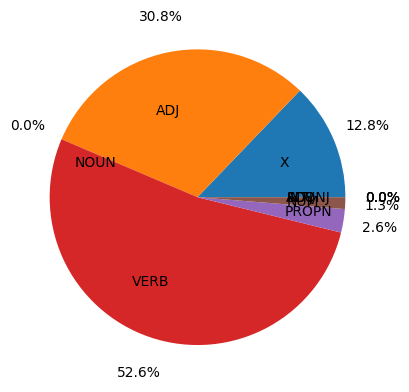

In [169]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(df_spacy_to_stanza.drop('NOT FIND').NOUN, labels=df_spacy_to_stanza.drop('NOT FIND').index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.show()

As we can see, the biggest POS given by **Stanza** to the tokens analyzed as NOUN by **Spacy**.

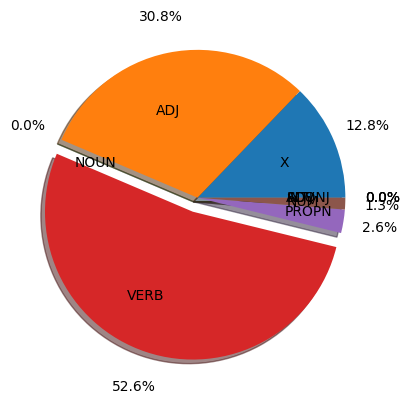

In [176]:
explode = [0.1 if (i == 'VERB') else 0 for i in df_spacy_to_stanza.drop('NOT FIND').index]

fig, ax = plt.subplots()
ax.pie(df_spacy_to_stanza.drop('NOT FIND').NOUN, explode = explode, labels=df_spacy_to_stanza.drop('NOT FIND').index, autopct='%1.1f%%', shadow=True, pctdistance=1.25, labeldistance=.6)
plt.show()

We can also discover the existence of an X category **TODO : Find the fuck it is**

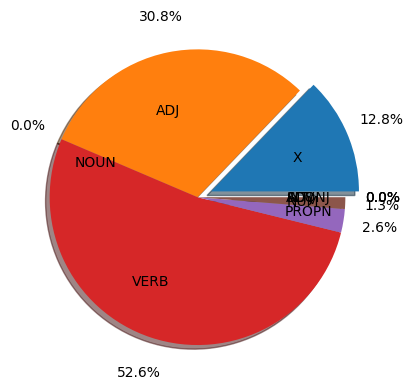

In [177]:
explode = [0.1 if (i == 'X') else 0 for i in df_spacy_to_stanza.drop('NOT FIND').index]

fig, ax = plt.subplots()
ax.pie(df_spacy_to_stanza.drop('NOT FIND').NOUN, explode = explode, labels=df_spacy_to_stanza.drop('NOT FIND').index, autopct='%1.1f%%', shadow=True, pctdistance=1.25, labeldistance=.6)
plt.show()

Let's now see the same chart but from **Stanza** to **Spacy**.

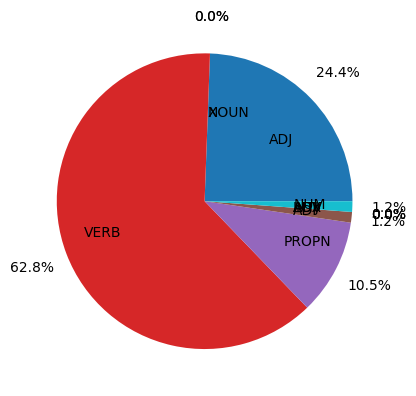

In [178]:
fig, ax = plt.subplots()
ax.pie(df_stanza_to_spacy.drop('NOT FIND').NOUN, labels=df_stanza_to_spacy.drop('NOT FIND').index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.show()

We can see that the VERB POS is also the biggest category but in an even higher proportion thant for **Spacy** to **Stanza**.

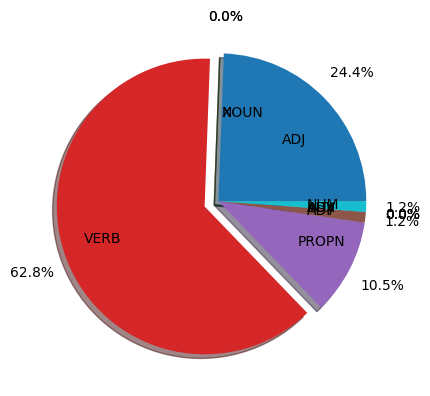

In [180]:
explode = [0.1 if (i == 'VERB') else 0 for i in df_stanza_to_spacy.drop('NOT FIND').index]

fig, ax = plt.subplots()
ax.pie(df_stanza_to_spacy.drop('NOT FIND').NOUN, explode = explode, labels=df_stanza_to_spacy.drop('NOT FIND').index, autopct='%1.1f%%', shadow=True, pctdistance=1.25, labeldistance=.6)
plt.show()

Interestingly the X category seems absent from the errors from **Stanza** to **Spacy**.

#### Verbs

We can do the same thing for the VERB UPOS. First from **Spacy** to **Stanza**.

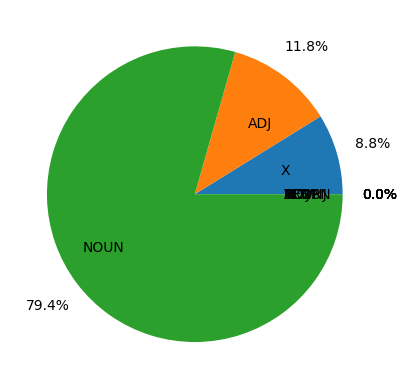

In [182]:
fig, ax = plt.subplots()
ax.pie(df_spacy_to_stanza.drop('NOT FIND').VERB, labels=df_spacy_to_stanza.drop('NOT FIND').index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.show()

The first category to come in that kind of errors is NOUN. This two categories seem linked.

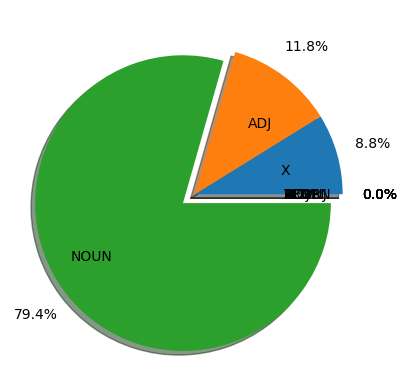

In [183]:
explode = [0.1 if (i == 'NOUN') else 0 for i in df_spacy_to_stanza.drop('NOT FIND').index]

fig, ax = plt.subplots()
ax.pie(df_spacy_to_stanza.drop('NOT FIND').VERB, explode = explode, labels=df_spacy_to_stanza.drop('NOT FIND').index, autopct='%1.1f%%', shadow=True, pctdistance=1.25, labeldistance=.6)
plt.show()

Now from **Stanza** to **Spacy**. We find the same thing.

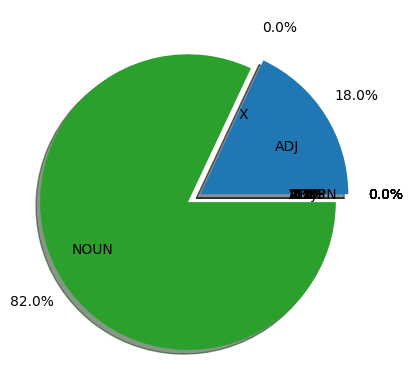

In [184]:
explode = [0.1 if (i == 'NOUN') else 0 for i in df_stanza_to_spacy.drop('NOT FIND').index]

fig, ax = plt.subplots()
ax.pie(df_stanza_to_spacy.drop('NOT FIND').VERB, explode = explode, labels=df_stanza_to_spacy.drop('NOT FIND').index, autopct='%1.1f%%', shadow=True, pctdistance=1.25, labeldistance=.6)
plt.show()

#### Adjectives

Finally let's do the same thing but with the adjectives. First from **Spacy** to **Stanza**.

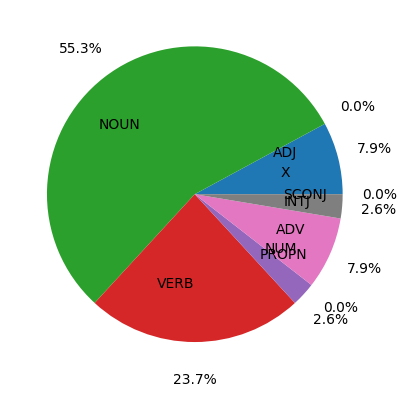

In [185]:
fig, ax = plt.subplots()
ax.pie(df_spacy_to_stanza.drop('NOT FIND').ADJ, labels=df_spacy_to_stanza.drop('NOT FIND').index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.show()

Then from **Stanza** to **Spacy**.

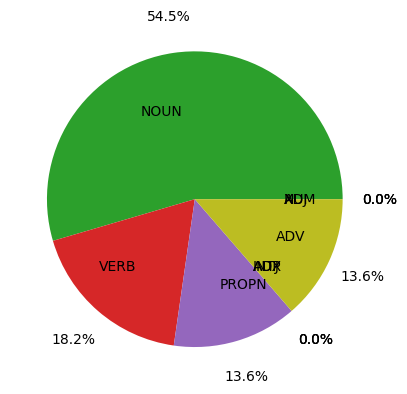

In [186]:
fig, ax = plt.subplots()
ax.pie(df_stanza_to_spacy.drop('NOT FIND').ADJ, labels=df_stanza_to_spacy.drop('NOT FIND').index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.show()